In [1]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
creds = '{"username":"","key":""}'

In [3]:
# for working with paths in Python, I recommend using `pathlib.Path`
from pathlib import Path

cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [4]:
path = Path('us-patent-phrase-to-phrase-matching')

In [5]:
if not iskaggle and not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [6]:
if iskaggle:
    path = Path('../input/us-patent-phrase-to-phrase-matching')
    ! pip install -q datasets

In [7]:
!ls {path}

sample_submission.csv  test.csv  train.csv


In [8]:
import pandas as pd

In [9]:
df = pd.read_csv(path/'train.csv')

In [10]:
df

id        anchor                  target context  score
0      37d61fd2272659b1     abatement  abatement of pollution     A47   0.50
1      7b9652b17b68b7a4     abatement          act of abating     A47   0.75
2      36d72442aefd8232     abatement         active catalyst     A47   0.25
3      5296b0c19e1ce60e     abatement     eliminating process     A47   0.50
4      54c1e3b9184cb5b6     abatement           forest region     A47   0.00
...                 ...           ...                     ...     ...    ...
36468  8e1386cbefd7f245  wood article          wooden article     B44   1.00
36469  42d9e032d1cd3242  wood article              wooden box     B44   0.50
36470  208654ccb9e14fa3  wood article           wooden handle     B44   0.50
36471  756ec035e694722b  wood article         wooden material     B44   0.75
36472  8d135da0b55b8c88  wood article        wooden substrate     B44   0.50

[36473 rows x 5 columns]

In [11]:
df.describe(include='object')

id                       anchor       target context
count              36473                        36473        36473   36473
unique             36473                          733        29340     106
top     37d61fd2272659b1  component composite coating  composition     H01
freq                   1                          152           24    2186

In [12]:
df['input'] = 'TEXT1: ' + df.context + '; TEXT2: ' + df.target + '; ANC1: ' + df.anchor

In [13]:
df.input.head()

0    TEXT1: A47; TEXT2: abatement of pollution; ANC...
1    TEXT1: A47; TEXT2: act of abating; ANC1: abate...
2    TEXT1: A47; TEXT2: active catalyst; ANC1: abat...
3    TEXT1: A47; TEXT2: eliminating process; ANC1: ...
4    TEXT1: A47; TEXT2: forest region; ANC1: abatement
Name: input, dtype: object

In [14]:
!pip install datasets

In [15]:
from datasets import Dataset,DatasetDict

ds = Dataset.from_pandas(df)

In [16]:
ds

Dataset({
    features: ['id', 'anchor', 'target', 'context', 'score', 'input'],
    num_rows: 36473
})

In [17]:
model_nm = 'microsoft/deberta-v3-small'

In [18]:
!pip install transformers

In [19]:
!pip install sentencepiece

In [20]:
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [21]:
tokz = AutoTokenizer.from_pretrained(model_nm)

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [22]:
tokz.tokenize("G'day folks, I'm Jeremy from fast.ai!")

['▁G',
 "'",
 'day',
 '▁folks',
 ',',
 '▁I',
 "'",
 'm',
 '▁Jeremy',
 '▁from',
 '▁fast',
 '.',
 'ai',
 '!']

In [23]:
tokz.tokenize("A platypus is an ornithorhynchus anatinus.")

['▁A',
 '▁platypus',
 '▁is',
 '▁an',
 '▁or',
 'ni',
 'tho',
 'rhynch',
 'us',
 '▁an',
 'at',
 'inus',
 '.']

In [24]:
def tok_func(x): return tokz(x["input"])

In [25]:
tok_ds = ds.map(tok_func, batched=True)

Map:   0%|          | 0/36473 [00:00<?, ? examples/s]

In [26]:
row = tok_ds[0]
row['input'], row['input_ids']

('TEXT1: A47; TEXT2: abatement of pollution; ANC1: abatement',
 [1,
  54453,
  435,
  294,
  336,
  5753,
  346,
  54453,
  445,
  294,
  47284,
  265,
  6435,
  346,
  23702,
  435,
  294,
  47284,
  2])

In [27]:
tokz.vocab['▁of']

265

In [28]:
tok_ds = tok_ds.rename_columns({'score':'labels'})

In [29]:
eval_df = pd.read_csv(path/'test.csv')
eval_df.describe()

id      anchor                         target context
count                 36          36                             36      36
unique                36          34                             36      29
top     4112d61851461f60  el display  inorganic photoconductor drum     G02
freq                   1           2                              1       3

In [30]:
def f(x): return -3*x**2 + 2*x + 20

In [31]:
import numpy as np, matplotlib.pyplot as plt

def plot_function(f, min=-2.1, max=2.1, color='r'):
    x = np.linspace(min,max, 100)[:,None]
    plt.plot(x, f(x), color)

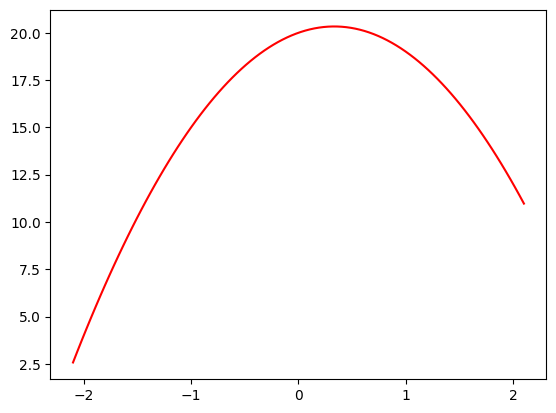

In [32]:
plot_function(f)

In [33]:
from numpy.random import normal,seed,uniform
np.random.seed(42)

In [34]:
def noise(x, scale): return normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

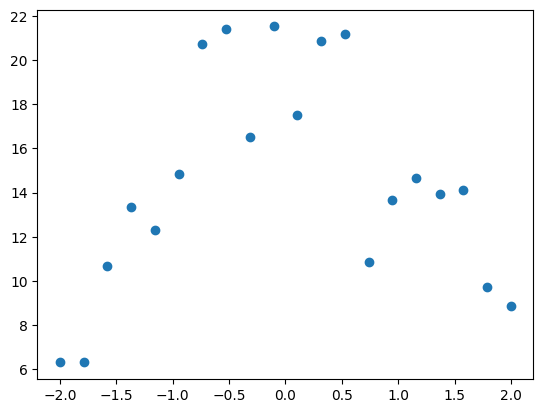

In [35]:
x = np.linspace(-2, 2, num=20)[:,None]
y = add_noise(f(x), 0.2, 1.3)
plt.scatter(x,y);

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plot_poly(degree):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(x, y)
    plt.scatter(x,y)
    plot_function(model.predict)

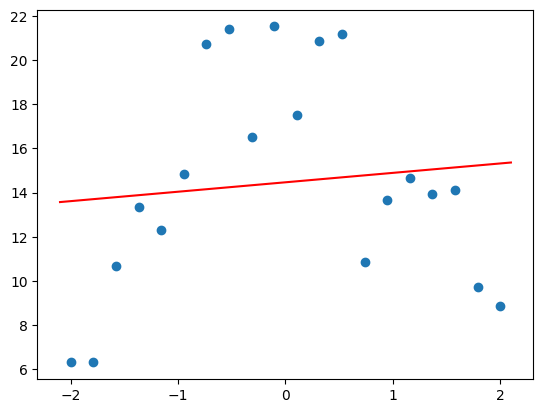

In [37]:
plot_poly(1)

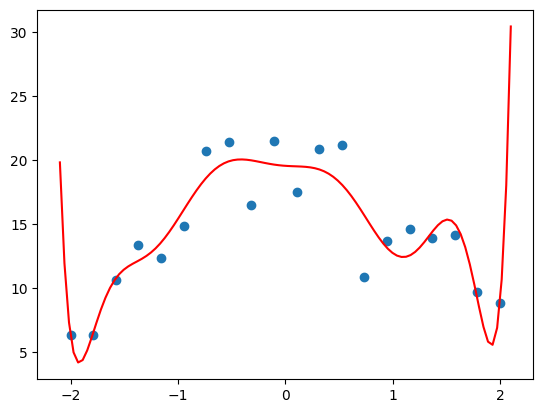

In [38]:
plot_poly(10)

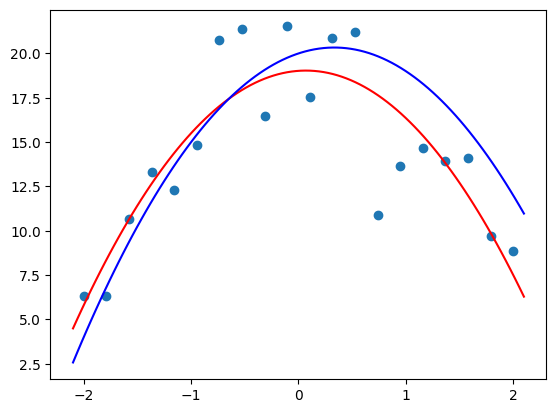

In [39]:
plot_poly(2)
plot_function(f, color='b')

In [40]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27354
    })
    test: Dataset({
        features: ['id', 'anchor', 'target', 'context', 'labels', 'input', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9119
    })
})

In [41]:
eval_df['input'] = 'TEXT1: ' + eval_df.context + '; TEXT2: ' + eval_df.target + '; ANC1: ' + eval_df.anchor
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [42]:
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing(as_frame=True)
housing = housing['data'].join(housing['target']).sample(1000, random_state=52)
housing.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
7506   3.0550      37.0  5.152778   1.048611       729.0  5.062500     33.92   
4720   3.0862      35.0  4.697897   1.055449      1159.0  2.216061     34.05   
12888  2.5556      24.0  4.864905   1.129222      1631.0  2.395007     38.66   
13344  3.0057      32.0  4.212687   0.936567      1378.0  5.141791     34.05   
7173   1.9083      42.0  3.888554   1.039157      1535.0  4.623494     34.05   

       Longitude  MedHouseVal  
7506     -118.28        1.054  
4720     -118.37        3.453  
12888    -121.35        1.057  
13344    -117.64        0.969  
7173     -118.19        1.192

In [43]:
np.set_printoptions(precision=2, suppress=True)

np.corrcoef(housing, rowvar=False)

array([[ 1.  , -0.12,  0.43, -0.08,  0.01, -0.07, -0.12,  0.04,  0.68],
       [-0.12,  1.  , -0.17, -0.06, -0.31,  0.  ,  0.03, -0.13,  0.12],
       [ 0.43, -0.17,  1.  ,  0.76, -0.09, -0.07,  0.12, -0.03,  0.21],
       [-0.08, -0.06,  0.76,  1.  , -0.08, -0.07,  0.09,  0.  , -0.04],
       [ 0.01, -0.31, -0.09, -0.08,  1.  ,  0.16, -0.15,  0.13,  0.  ],
       [-0.07,  0.  , -0.07, -0.07,  0.16,  1.  , -0.16,  0.17, -0.27],
       [-0.12,  0.03,  0.12,  0.09, -0.15, -0.16,  1.  , -0.93, -0.16],
       [ 0.04, -0.13, -0.03,  0.  ,  0.13,  0.17, -0.93,  1.  , -0.03],
       [ 0.68,  0.12,  0.21, -0.04,  0.  , -0.27, -0.16, -0.03,  1.  ]])

In [44]:
np.corrcoef(housing.MedInc, housing.MedHouseVal)

array([[1.  , 0.68],
       [0.68, 1.  ]])

In [45]:
def corr(x,y): return np.corrcoef(x,y)[0][1]

corr(housing.MedInc, housing.MedHouseVal)

0.6760250732906006

In [46]:
def show_corr(df, a, b):
    x,y = df[a],df[b]
    plt.scatter(x,y, alpha=0.5, s=4)
    plt.title(f'{a} vs {b}; r: {corr(x, y):.2f}')

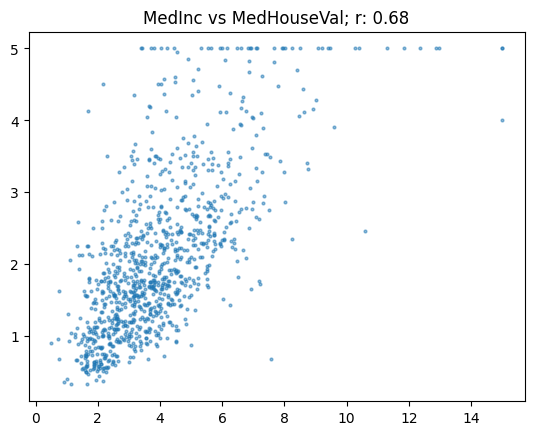

In [47]:
show_corr(housing, 'MedInc', 'MedHouseVal')

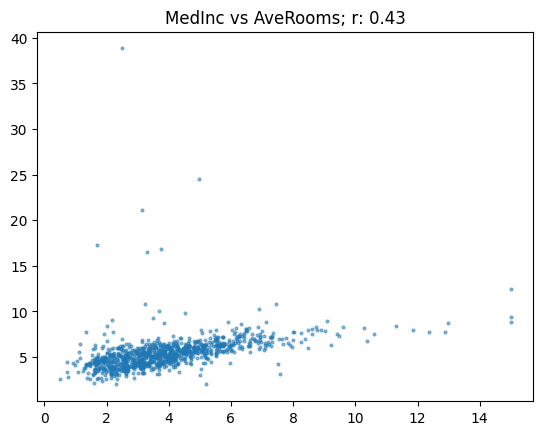

In [48]:
show_corr(housing, 'MedInc', 'AveRooms')

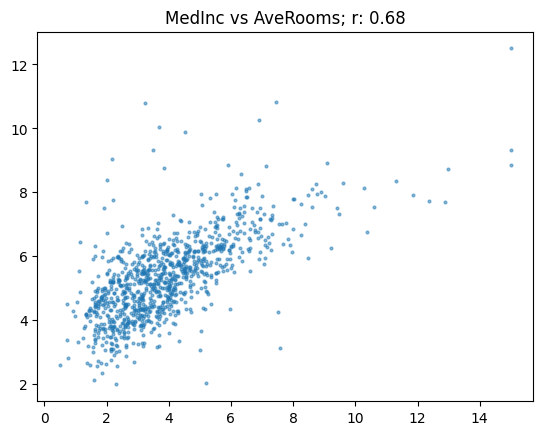

In [49]:
subset = housing[housing.AveRooms<15]
show_corr(subset, 'MedInc', 'AveRooms')

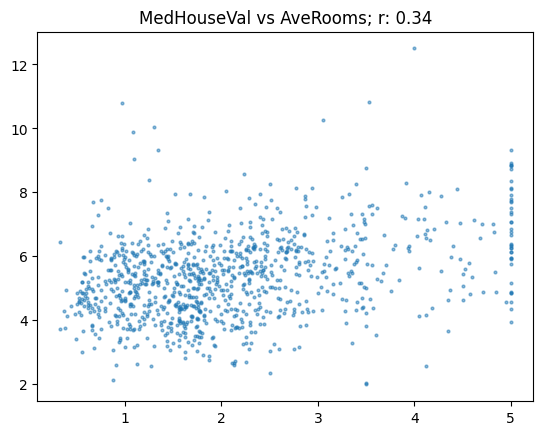

In [50]:
show_corr(subset, 'MedHouseVal', 'AveRooms')

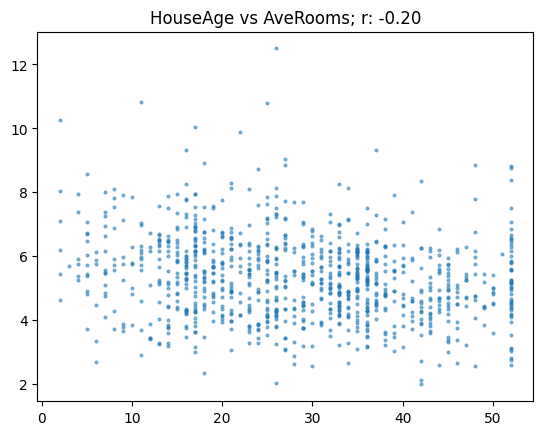

In [51]:
show_corr(subset, 'HouseAge', 'AveRooms')

In [52]:
def corr_d(eval_pred): return {'pearson': corr(*eval_pred)}

In [53]:
!pip install accelerate

In [54]:
from transformers import TrainingArguments,Trainer

In [55]:
bs = 128
epochs = 4

In [56]:
lr = 8e-5

In [57]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none')

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=corr_d)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['pooler.dense.bias', 'classifier.bias', 'pooler.dense.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [59]:
trainer.train();

You're using a DebertaV2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [60]:
preds = trainer.predict(eval_ds).predictions.astype(float)
preds

array([[ 0.51],
       [ 0.68],
       [ 0.48],
       [ 0.38],
       [-0.02],
       [ 0.55],
       [ 0.55],
       [-0.02],
       [ 0.34],
       [ 1.11],
       [ 0.28],
       [ 0.25],
       [ 0.72],
       [ 0.98],
       [ 0.72],
       [ 0.5 ],
       [ 0.32],
       [-0.03],
       [ 0.62],
       [ 0.38],
       [ 0.49],
       [ 0.25],
       [ 0.07],
       [ 0.26],
       [ 0.6 ],
       [-0.02],
       [-0.03],
       [-0.03],
       [-0.03],
       [ 0.64],
       [ 0.31],
       [-0.01],
       [ 0.76],
       [ 0.56],
       [ 0.47],
       [ 0.22]])

In [61]:
preds = np.clip(preds, 0, 1)

In [62]:
preds

array([[0.51],
       [0.68],
       [0.48],
       [0.38],
       [0.  ],
       [0.55],
       [0.55],
       [0.  ],
       [0.34],
       [1.  ],
       [0.28],
       [0.25],
       [0.72],
       [0.98],
       [0.72],
       [0.5 ],
       [0.32],
       [0.  ],
       [0.62],
       [0.38],
       [0.49],
       [0.25],
       [0.07],
       [0.26],
       [0.6 ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.64],
       [0.31],
       [0.  ],
       [0.76],
       [0.56],
       [0.47],
       [0.22]])

In [63]:
import datasets

submission = datasets.Dataset.from_dict({
    'id': eval_ds['id'],
    'score': preds
})

submission.to_csv('submission.csv', index=False)

Creating CSV from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

853